# Dataset split of AotM-2011/30Music playlists for playlist generation

### when a user in test set is known previously (warm user)

In [1]:
%matplotlib inline

import os
import sys
import gzip
import numpy as np
import pickle as pkl
from scipy.sparse import lil_matrix, issparse, hstack, vstack
from collections import Counter
import gensim

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np_settings0 = np.seterr(all='raise')
RAND_SEED = 0
plt.style.use('seaborn')

In [3]:
datasets = ['aotm2011', '30music']
ffeature = 'data/msd/song2feature.pkl.gz'
fgenre = 'data/msd/song2genre.pkl.gz'
fsong2artist = 'data/msd/song2artist.pkl.gz'
audio_feature_indices = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 185, 186, 187, 198, 199, 200, 201]
test_ratios = [0.19, 0.5]

In [4]:
dix = 0
dataset_name = datasets[dix]
data_dir = 'data/%s' % dataset_name
print(dataset_name)

aotm2011


## Load playlists

Load playlists.

In [5]:
fplaylist = os.path.join(data_dir, '%s-playlist.pkl.gz' % dataset_name)
_all_playlists = pkl.load(gzip.open(fplaylist, 'rb'))

In [6]:
# _all_playlists[0]

In [7]:
all_playlists = []

if type(_all_playlists[0][1]) == tuple:
    for pl, u in _all_playlists:
        user = '%s_%s' % (u[0], u[1])  # user string
        all_playlists.append((pl, user))
else:
    all_playlists = _all_playlists

In [8]:
# user_playlists = dict()
# for pl, u in all_playlists:
#     try:
#         user_playlists[u].append(pl)
#     except KeyError:
#         user_playlists[u] = [pl]

In [9]:
# all_playlists = []
# for u in user_playlists:
#     if len(user_playlists[u]) > 4:
#         all_playlists += [(pl, u) for pl in user_playlists[u]]

In [10]:
all_users = sorted(set({user for _, user in all_playlists}))

In [11]:
print('#user    : {:,}'.format(len(all_users)))
print('#playlist: {:,}'.format(len(all_playlists)))

#user    : 14,182
#playlist: 84,710


Average playlist length: 10.1


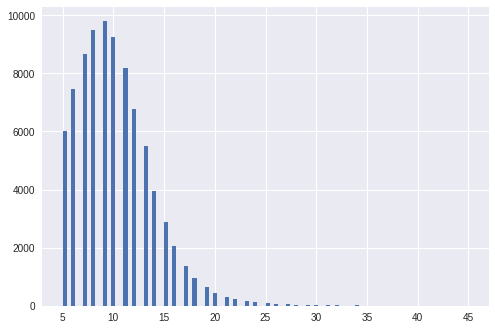

In [12]:
pl_lengths = [len(pl) for pl, _ in all_playlists]
plt.hist(pl_lengths, bins=100)
print('Average playlist length: %.1f' % np.mean(pl_lengths))

check duplicated songs in the same playlist.

In [13]:
print('{:,} | {:,}'.format(np.sum(pl_lengths), np.sum([len(set(pl)) for pl, _ in all_playlists])))

857,782 | 857,782


## Load song features

Load `song_id` --> `feature array` mapping: map a song to the audio features of one of its corresponding tracks in MSD.

In [14]:
_song2feature = pkl.load(gzip.open(ffeature, 'rb'))

In [15]:
song2feature = dict()

for sid in sorted(_song2feature):
    song2feature[sid] = _song2feature[sid][audio_feature_indices]

## Load genres

Song genres from [MSD Allmusic Genre Dataset (Top MAGD)](http://www.ifs.tuwien.ac.at/mir/msd/TopMAGD.html) and [tagtraum](http://www.tagtraum.com/msd_genre_datasets.html).

In [16]:
song2genre = pkl.load(gzip.open(fgenre, 'rb'))

## Song collection

In [17]:
_all_songs = sorted([(sid, int(song2feature[sid][-1])) for sid in {s for pl, _ in all_playlists for s in pl}], 
                   key=lambda x: (x[1], x[0]))
print('{:,}'.format(len(_all_songs)))

114,428


Randomise the order of song with the same age.

In [18]:
song_age_dict = dict()

for sid, age in _all_songs:
    age = int(age)
    try:
        song_age_dict[age].append(sid)
    except KeyError:
        song_age_dict[age] = [sid]

In [19]:
all_songs = []

np.random.seed(RAND_SEED)
for age in sorted(song_age_dict.keys()):
    all_songs += [(sid, age) for sid in np.random.permutation(song_age_dict[age])]

In [20]:
pkl.dump(all_songs, gzip.open(os.path.join(data_dir, 'setting3/all_songs.pkl.gz'), 'wb'))

Check if all songs have genre info.

In [21]:
print('#songs missing genre: {:,}'.format(len(all_songs) - np.sum([sid in song2genre for (sid, _) in all_songs])))

#songs missing genre: 33,907


Song popularity.

In [22]:
song2index = {sid: ix for ix, (sid, _) in enumerate(all_songs)}
song_pl_mat = lil_matrix((len(all_songs), len(all_playlists)), dtype=np.int8)
for j in range(len(all_playlists)):
    pl = all_playlists[j][0]
    ind = [song2index[sid] for sid in pl]
    song_pl_mat[ind, j] = 1

In [23]:
song_pop = song_pl_mat.tocsc().sum(axis=1)

In [24]:
max_pop = np.max(song_pop)
max_pop

812

In [25]:
song2pop = {sid: song_pop[song2index[sid], 0] for (sid, _) in all_songs}

In [26]:
pkl.dump(song2pop, gzip.open(os.path.join(data_dir, 'setting3/song2pop.pkl.gz'), 'wb'))

## Create song-playlist matrix

Songs as rows, playlists as columns.

In [27]:
def gen_dataset(playlists, song2feature, song2genre, song2artist, artist2vec, 
                train_song_set, dev_song_set=[], test_song_set=[], song2pop_train=None):
    """
    Create labelled dataset: rows are songs, columns are users.
    
    Input:
        - playlists: a set of playlists
        - train_song_set: a list of songIDs in training set
        - dev_song_set: a list of songIDs in dev set
        - test_song_set: a list of songIDs in test set
        - song2feature: dictionary that maps songIDs to features from MSD
        - song2genre: dictionary that maps songIDs to genre
        - song2pop_train: a dictionary that maps songIDs to its popularity
    Output:
        - (Feature, Label) pair (X, Y)
          X: #songs by #features
          Y: #songs by #users
    """ 
    song_set = train_song_set + dev_song_set + test_song_set
    N = len(song_set)
    K = len(playlists)
    
    genre_set = sorted({v for v in song2genre.values()})
    genre2index = {genre: ix for ix, genre in enumerate(genre_set)}
    
    def onehot_genre(songID):
        """
        One-hot encoding of genres.
        Data imputation: 
            - mean imputation (default)
            - one extra entry for songs without genre info
            - sampling from the distribution of genre popularity
        """
        num = len(genre_set) # + 1
        vec = np.zeros(num, dtype=np.float)
        if songID in song2genre:
            genre_ix = genre2index[song2genre[songID]]
            vec[genre_ix] = 1
        else:
            vec[:] = np.nan
            #vec[-1] = 1
        return vec
    
    def song_artist_feature(songID):
        """
        Return the artist feature for a given song
        """
        if songID in song2artist:
            aid = song2artist[songID]
            return artist2vec[aid]
        else:
            return artist2vec['$UNK$']
    
    X = np.array([np.concatenate([song2feature[sid], song_artist_feature(sid), onehot_genre(sid)], axis=-1) \
                  for sid in song_set])
    Y = lil_matrix((N, K), dtype=np.bool)
    
    song2index = {sid: ix for ix, sid in enumerate(song_set)}
    for k in range(K):
        pl = playlists[k]
        indices = [song2index[sid] for sid in pl if sid in song2index]
        Y[indices, k] = True
        
    # genre imputation
    genre_ix_start = -len(genre_set)
    genre_nan = np.isnan(X[:, genre_ix_start:])
    genre_mean = np.nansum(X[:, genre_ix_start:], axis=0) / (X.shape[0] - np.sum(genre_nan, axis=0))
    #print(np.nansum(X[:, genre_ix_start:], axis=0))
    #print(genre_set)
    #print(genre_mean)
    for j in range(len(genre_set)):
        X[genre_nan[:,j], j+genre_ix_start] = genre_mean[j]
        
    # normalise the sum of all genres per song to 1
    # X[:, -len(genre_set):] /= X[:, -len(genre_set):].sum(axis=1).reshape(-1, 1)  
    # NOTE: this is not necessary, as the imputed values are guaranteed to be normalised (sum to 1) 
    # due to the above method to compute mean genres.
    
    # the log of song popularity
    if song2pop_train is not None:
        # for sid in song_set: 
        #     assert sid in song2pop_train  # trust the input
        logsongpop = np.log2([song2pop_train[sid]+1 for sid in song_set])  # deal with 0 popularity
        X = np.hstack([X, logsongpop.reshape(-1, 1)])

    #return X, Y
    Y = Y.tocsr()
    
    train_ix = [song2index[sid] for sid in train_song_set]
    X_train = X[train_ix, :]
    Y_train = Y[train_ix, :]
    
    dev_ix = [song2index[sid] for sid in dev_song_set]
    X_dev = X[dev_ix, :]
    Y_dev = Y[dev_ix, :]
    
    test_ix = [song2index[sid] for sid in test_song_set]
    X_test = X[test_ix, :]
    Y_test = Y[test_ix, :]
    
    if len(dev_song_set) > 0:
        if len(test_song_set) > 0:
            return X_train, Y_train.tocsc(), X_dev, Y_dev.tocsc(), X_test, Y_test.tocsc()
        else:
            return X_train, Y_train.tocsc(), X_dev, Y_dev.tocsc()
    else:
        if len(test_song_set) > 0:
            return X_train, Y_train.tocsc(), X_test, Y_test.tocsc()
        else:
            return X_train, Y_train.tocsc()

## Split playlists

Split playlists such that 
- a subset of selected user's playlist are in test set.
- every song in test set is also in training set.  

In [28]:
user_playlists = dict()
for j in range(len(all_playlists)):
    u = all_playlists[j][1]
    try: 
        user_playlists[u].append(j)
    except KeyError:
        user_playlists[u] = [j]

In [29]:
# sanity check
npl_all = np.sum([len(user_playlists[u]) for u in user_playlists])
print('{:30s} {:,}'.format('#users:', len(user_playlists)))
print('{:30s} {:,}'.format('#playlists:', npl_all))
print('{:30s} {:.1f}'.format('Average #playlists per user:', npl_all / len(user_playlists)))

#users:                        14,182
#playlists:                    84,710
Average #playlists per user:   6.0


In [30]:
candidate_pl_indices = set()
other_pl_indices = set()

for i in range(len(all_playlists)):
    pl = all_playlists[i][0]
    if np.all(np.asarray([song2pop[sid] for sid in pl]) >= 5):
        candidate_pl_indices.add(i)
    else:
        other_pl_indices.add(i)

In [31]:
print(len(candidate_pl_indices), len(other_pl_indices))

30210 54500


In [32]:
train_playlist_indices = []
test_playlist_indices  = []

np.random.seed(RAND_SEED)
test_ratio = test_ratios[dix]
print(test_ratio)
for u in sorted(user_playlists):
    pl_indices_u = sorted(user_playlists[u])
    if len(pl_indices_u) < 2:
        train_playlist_indices += pl_indices_u
    else:
        pl_indices = [j for j in pl_indices_u if j in candidate_pl_indices]
        npl_test = int(test_ratio * len(pl_indices_u))
        if len(pl_indices) <= npl_test:
            test_playlist_indices += pl_indices
            train_playlist_indices += sorted(set(pl_indices_u) - set(pl_indices))
        else:
            pl_indices = np.random.permutation(pl_indices).tolist()
            test_playlist_indices += pl_indices[:npl_test]
            train_playlist_indices += sorted(set(pl_indices_u) - set(pl_indices[:npl_test]))
            
train_playlists = [all_playlists[j] for j in train_playlist_indices]
test_playlists = [all_playlists[j] for j in test_playlist_indices]

0.19


Every song in test set should also be in training set.

In [33]:
print('#Songs in train set: %d, #Songs total: %d' % \
      (len(set([sid for pl, _ in train_playlists for sid in pl])), len(all_songs)))

#Songs in train set: 114428, #Songs total: 114428


In [34]:
print('{:30s} {:,}'.format('#playlists in training set:', len(train_playlists)))
print('{:30s} {:,}'.format('#playlists in test set:', len(test_playlists)))
print('{:30s} {:,} out of {:,}'.format('#users in test set:', len({u for _, u in test_playlists}), len(all_users)))

#playlists in training set:    75,477
#playlists in test set:        9,233
#users in test set:            2,722 out of 14,182


In [35]:
xmax = np.max([len(pl) for (pl, _) in all_playlists]) + 1

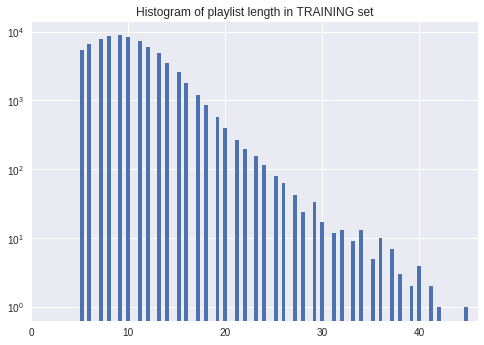

In [36]:
ax = plt.subplot(111)
ax.hist([len(pl) for (pl, _) in train_playlists], bins=100)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
ax.set_title('Histogram of playlist length in TRAINING set')
pass

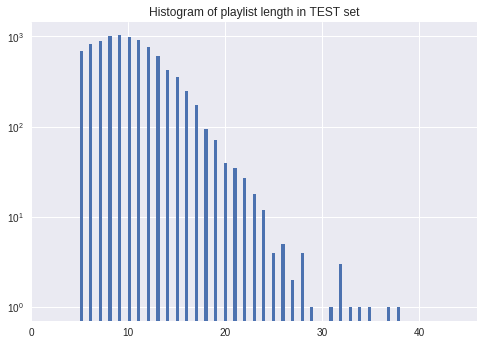

In [37]:
ax = plt.subplot(111)
ax.hist([len(pl) for (pl, _) in test_playlists], bins=100)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
ax.set_title('Histogram of playlist length in TEST set')
pass

In [38]:
song2pop_train = song2pop.copy()
for pl, _ in test_playlists:
    for sid in pl:
        song2pop_train[sid] -= 1

In [39]:
pkl.dump(song2pop_train, gzip.open(os.path.join(data_dir, 'setting3/song2pop_train.pkl.gz'), 'wb'))

## Learn artist features

In [40]:
song2artist = pkl.load(gzip.open(fsong2artist, 'rb'))

In [41]:
artist_playlist = []

for pl, _ in train_playlists:
    pl_artists = [song2artist[sid] if sid in song2artist else '$UNK$' for sid in pl]
    artist_playlist.append(pl_artists)

In [42]:
fartist2vec_bin = os.path.join(data_dir, 'setting3/artist2vec.bin')
if os.path.exists(fartist2vec_bin):
    artist2vec = gensim.models.KeyedVectors.load_word2vec_format(fartist2vec_bin, binary=True)
else:
    artist2vec_model = gensim.models.Word2Vec(sentences=artist_playlist, size=50, seed=RAND_SEED, 
                                              window=10, iter=10, min_count=1)
    artist2vec_model.wv.save_word2vec_format(fartist2vec_bin, binary=True)
    artist2vec = artist2vec_model.wv

## Hold a subset of playlists, use all songs

In [43]:
pkl_dir = os.path.join(data_dir, 'setting3')
fpl     = os.path.join(pkl_dir, 'playlists_train_test_s3.pkl.gz')
fx      = os.path.join(pkl_dir, 'X.pkl.gz')
fytrain = os.path.join(pkl_dir, 'Y_train.pkl.gz')
fytest  = os.path.join(pkl_dir, 'Y_test.pkl.gz')
fclique_train = os.path.join(pkl_dir, 'cliques_train.pkl.gz')
fclique_all = os.path.join(pkl_dir, 'cliques_all.pkl.gz')

In [44]:
X, Y = gen_dataset(playlists = [t[0] for t in train_playlists + test_playlists],
                   song2feature = song2feature, song2genre = song2genre, 
                   song2artist = song2artist, artist2vec = artist2vec, 
                   train_song_set = [t[0] for t in all_songs], song2pop_train=song2pop_train)

In [45]:
split_ix = len(train_playlists)

In [46]:
Y_train = Y[:, :split_ix].tocsc()
Y_test = Y[:, split_ix:].tocsc()

In [47]:
assert Y_train.shape[0] == Y_test.shape[0] == X.shape[0] == len(all_songs)
assert Y_train.shape[1] + Y_test.shape[1] == Y.shape[1] == len(all_playlists)

In [48]:
pkl.dump({'train_playlists': train_playlists, 'test_playlists': test_playlists}, gzip.open(fpl, 'wb'))

Feature normalisation.

In [49]:
X_mean = np.mean(X, axis=0).reshape((1, -1))
X_std = np.std(X, axis=0).reshape((1, -1)) + 10 ** (-6)
X -= X_mean
X /= X_std

In [50]:
print(np.mean(np.mean(X, axis=0)))
print(np.mean( np.std(X, axis=0)) - 1)

1.9730738564122102e-14
-0.02410121139805943


In [51]:
print('Train :', Y_train.shape)
print('Test  :', Y_test.shape)
print('All: %s, %s' % (X.shape, Y.shape))

Train : (114428, 75477)
Test  : (114428, 9233)
All: (114428, 83), (114428, 84710)


In [52]:
pkl.dump(X,       gzip.open(fx, 'wb'))
pkl.dump(Y_train, gzip.open(fytrain, 'wb'))
pkl.dump(Y_test,  gzip.open(fytest, 'wb'))

Playlists of the same user form a *clique*.

Cliques in train set.

In [53]:
pl_users = [u for (_, u) in train_playlists]
cliques_train = []
for u in sorted(set(pl_users)):
    clique = np.where(u == np.array(pl_users, dtype=np.object))[0]
    cliques_train.append(clique)

In [54]:
pkl.dump(cliques_train, gzip.open(fclique_train, 'wb'))

In [55]:
clqsize = [len(clq) for clq in cliques_train]
print(np.min(clqsize), np.max(clqsize), len(clqsize), np.sum(clqsize))

1 689 14182 75477


In [56]:
assert np.all(np.arange(Y_train.shape[1]) == np.asarray(sorted([k for clq in cliques_train for k in clq])))

Cliques in train + test set.

In [57]:
pl_users = [u for (_, u) in train_playlists + test_playlists]
clique_all = []
for u in sorted(set(pl_users)):
    clique = np.where(u == np.array(pl_users, dtype=np.object))[0]
    #if len(clique) > 1:
    clique_all.append(clique)

In [58]:
pkl.dump(clique_all, gzip.open(fclique_all, 'wb'))

In [59]:
clqsize = [len(clq) for clq in clique_all]
print(np.min(clqsize), np.max(clqsize), len(clqsize), np.sum(clqsize))

1 850 14182 84710


In [60]:
assert np.all(np.arange(Y.shape[1]) == np.asarray(sorted([k for clq in clique_all for k in clq])))